# IMO - Zadanie 1

Autorzy: Dariusz Max Adamski, Sławomir Gilewski

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import multiprocessing as mp
from tqdm.notebook import tqdm
from scipy.special import expit
import seaborn as sns
plt.rc('figure', dpi=110, figsize=(9, 5))
sns.set_style('darkgrid')

In [2]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

def score_diff(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]

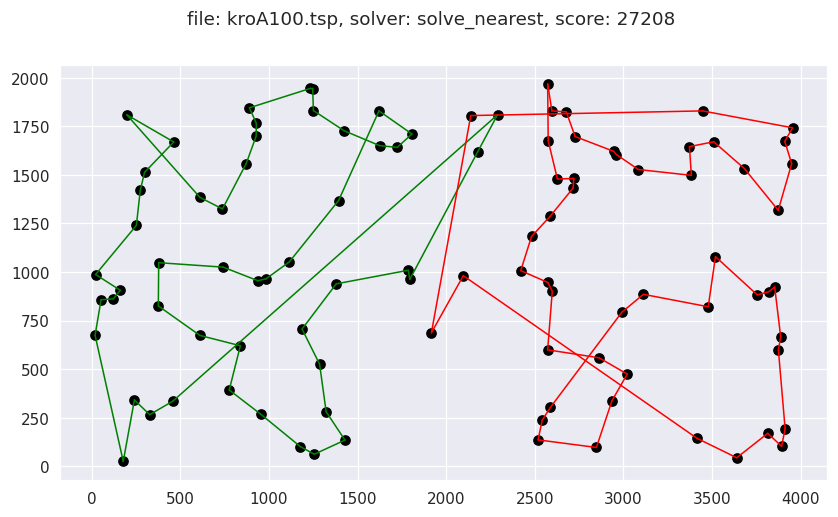

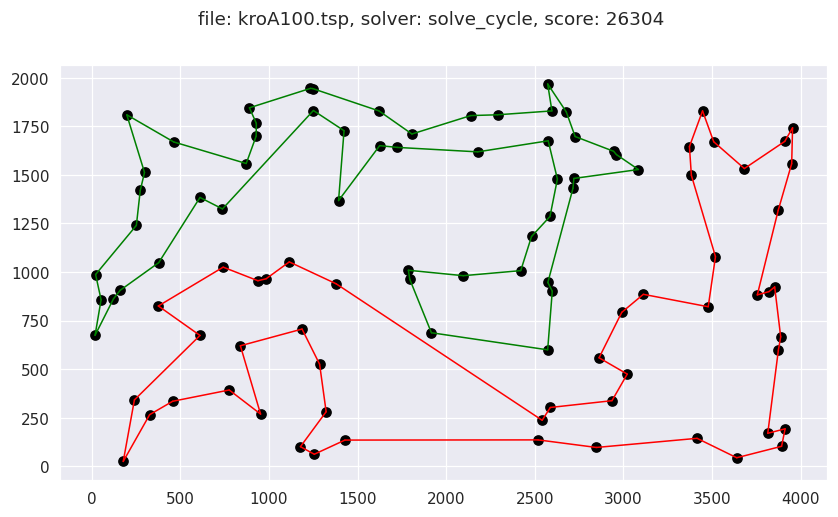

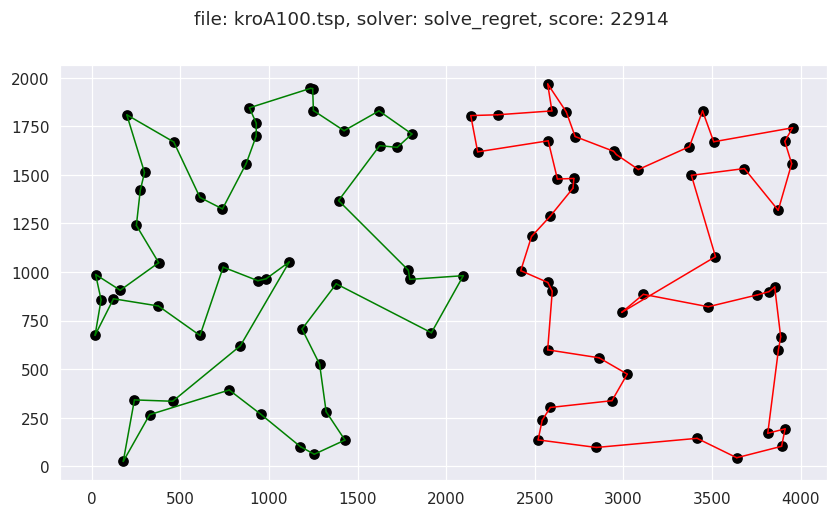

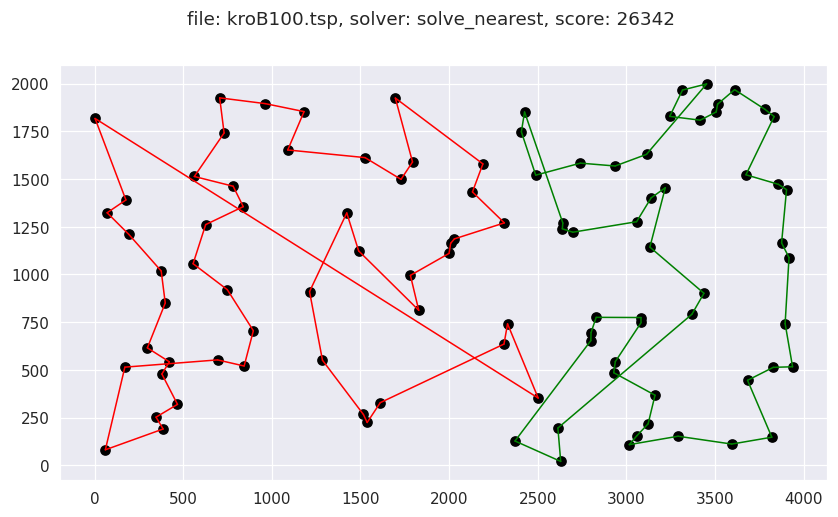

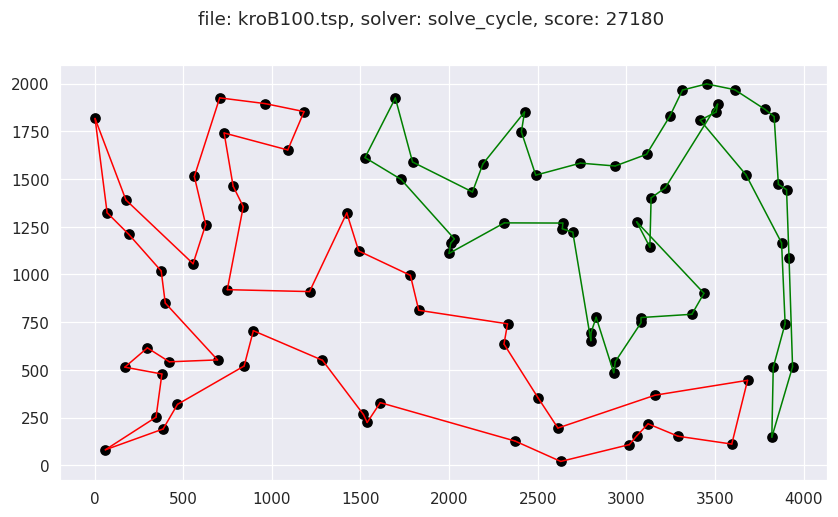

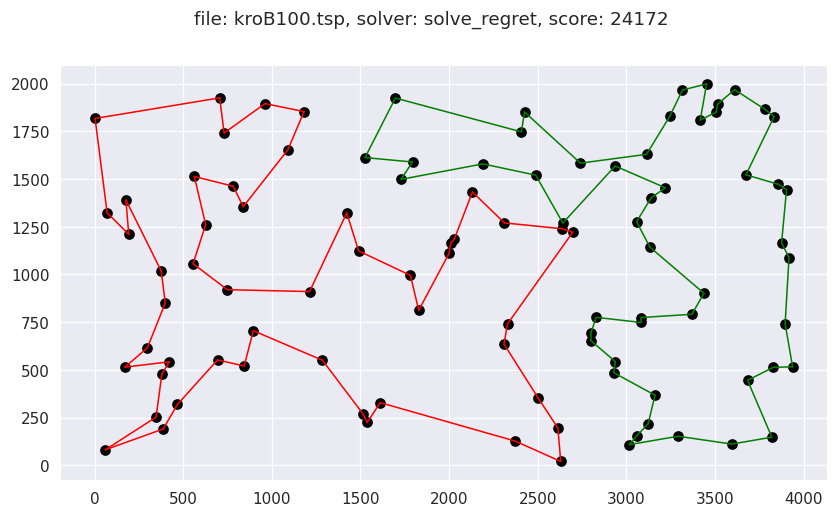

,file,function,min,mean,max
0,kroA100.tsp,solve_nearest,27208,32496,35514
1,kroA100.tsp,solve_cycle,26304,28708,29980
2,kroA100.tsp,solve_regret,22914,26840,29510
3,kroB100.tsp,solve_nearest,26342,32325,40264
4,kroB100.tsp,solve_cycle,27180,28538,30197
5,kroB100.tsp,solve_regret,24172,27767,29378


In [32]:
def solve_nearest(args):
    # greedy nearest
    cities, start = args
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    cycles = [[a], [b]]
    while remaining:
        for cycle in cycles:
            best_city = remaining[np.argmin(cities[cycle[-1], remaining])]
            cycle.append(best_city)
            remaining.remove(best_city)
    return cycles

def solve_cycle(args):
    # greedy cycle
    cities, start = args
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[score_diff(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx, best_insert = np.unravel_index(np.argmin(scores), scores.shape)
            best_city = remaining[best_city_idx]
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return paths

def solve_regret(args):
    # greedy 2-regret
    cities, start = args
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[score_diff(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return paths
    
def show_results():
    results = []
    for file in ['kroA100.tsp', 'kroB100.tsp']:
        cities, coords = read_instance(file)
        for solve in [solve_nearest, solve_cycle, solve_regret]:
            solutions = mp.Pool().map(solve, [(cities, i) for i in range(100)])
            scores = [score(cities, x) for x in solutions]
            best = solutions[np.argmin(scores)]
            plt.subplots()
            plt.suptitle(f'file: {file}, solver: {solve.__name__}, score: {int(min(scores))}')
            draw_path(coords, best[0], color='green')
            draw_path(coords, best[1], color='red')
            plt.scatter(coords.x, coords.y, color='black')
            plt.show()
            results.append(dict(file=file, function=solve.__name__, min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))

    return pd.DataFrame(results)

show_results()